In [13]:
using DifferentialEquations, DiffEqProblemLibrary, ParameterizedFunctions, Plots, ODE, ODEInterfaceDiffEq, LSODA
gr(fmt=:png)

van = @ode_def VanDerPol2 begin
  dy = μ*((1-x^2)*y - x)
  dx = 1*y
end μ

prob = ODEProblem(van,[0;2.],(0.0,6.3),1e6)
abstols = 1./10.^(5:9)
reltols = 1./10.^(2:6)

sol = solve(prob,radau(),abstol=1/10^14,reltol=1/10^14)
test_sol = TestSolution(sol)
sol2 = solve(prob,Rodas4(),abstol=1/10^11,reltol=1/10^11,maxiters=1e7)
test_sol2 = TestSolution(sol2)

retcode: Success
Interpolation: specialized 3rd order "free" stiffness-aware interpolation
t: nothing
u: nothing

### Plot Test

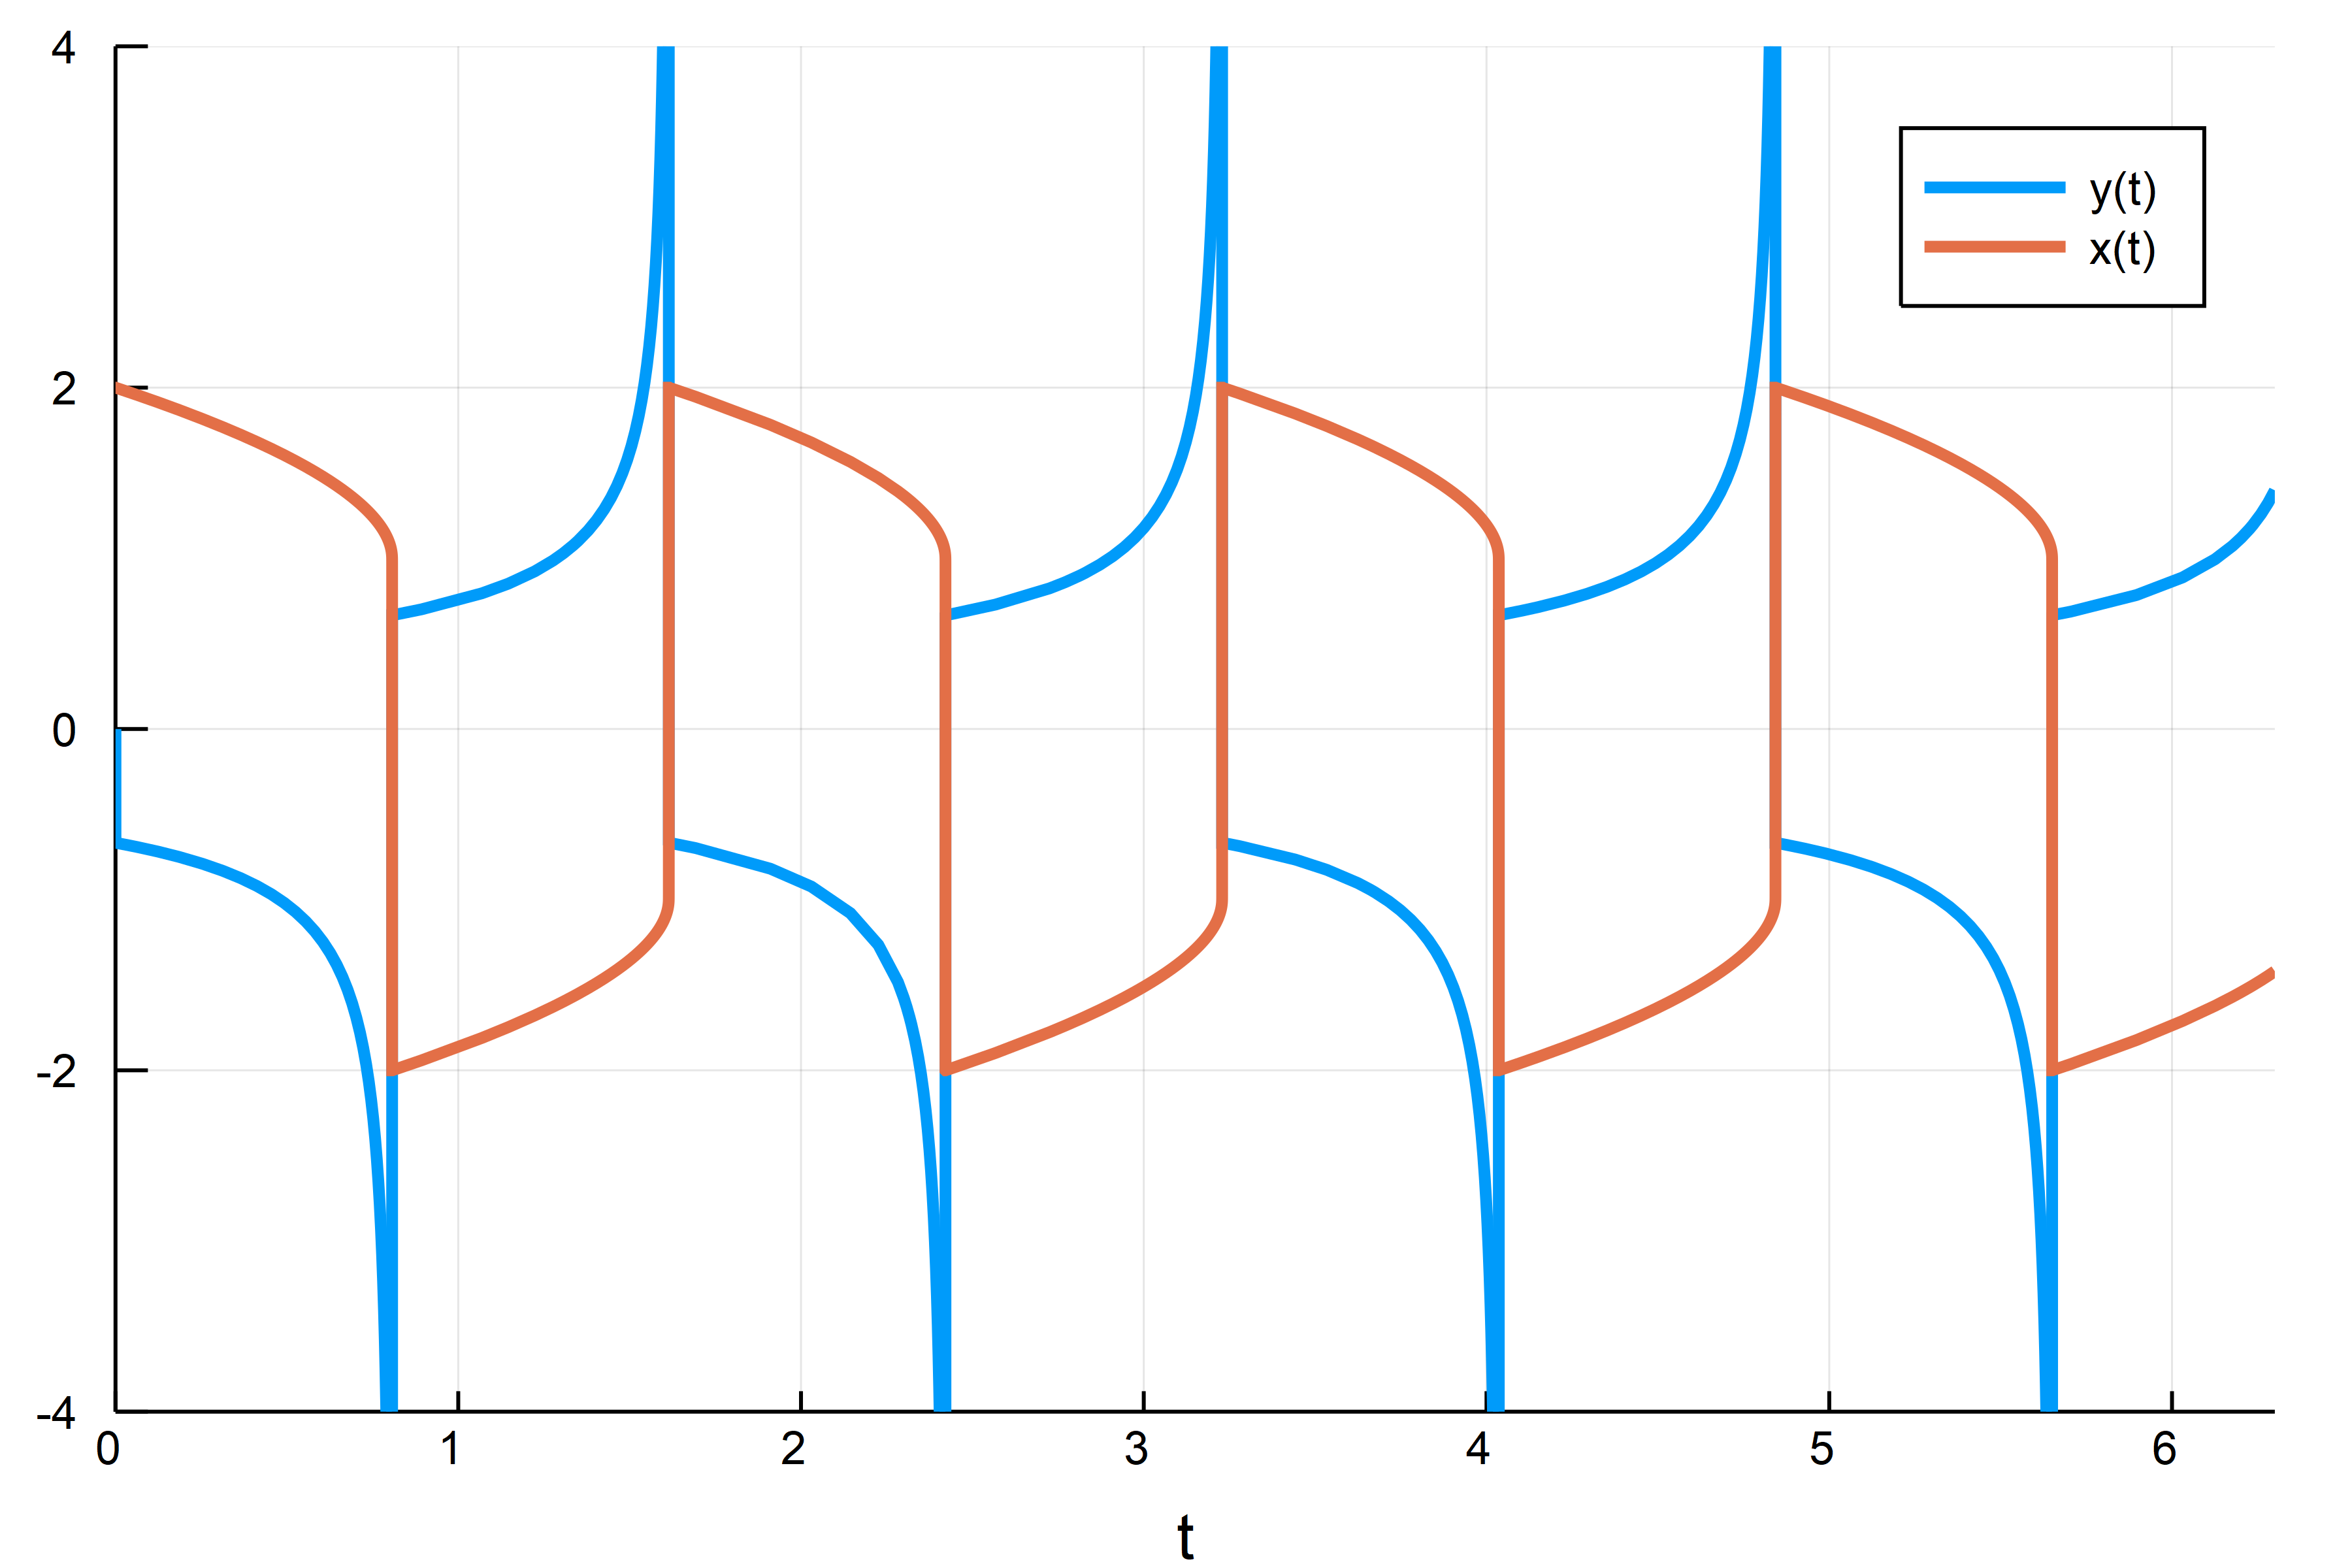

In [14]:
plot(sol,ylim=[-4;4])

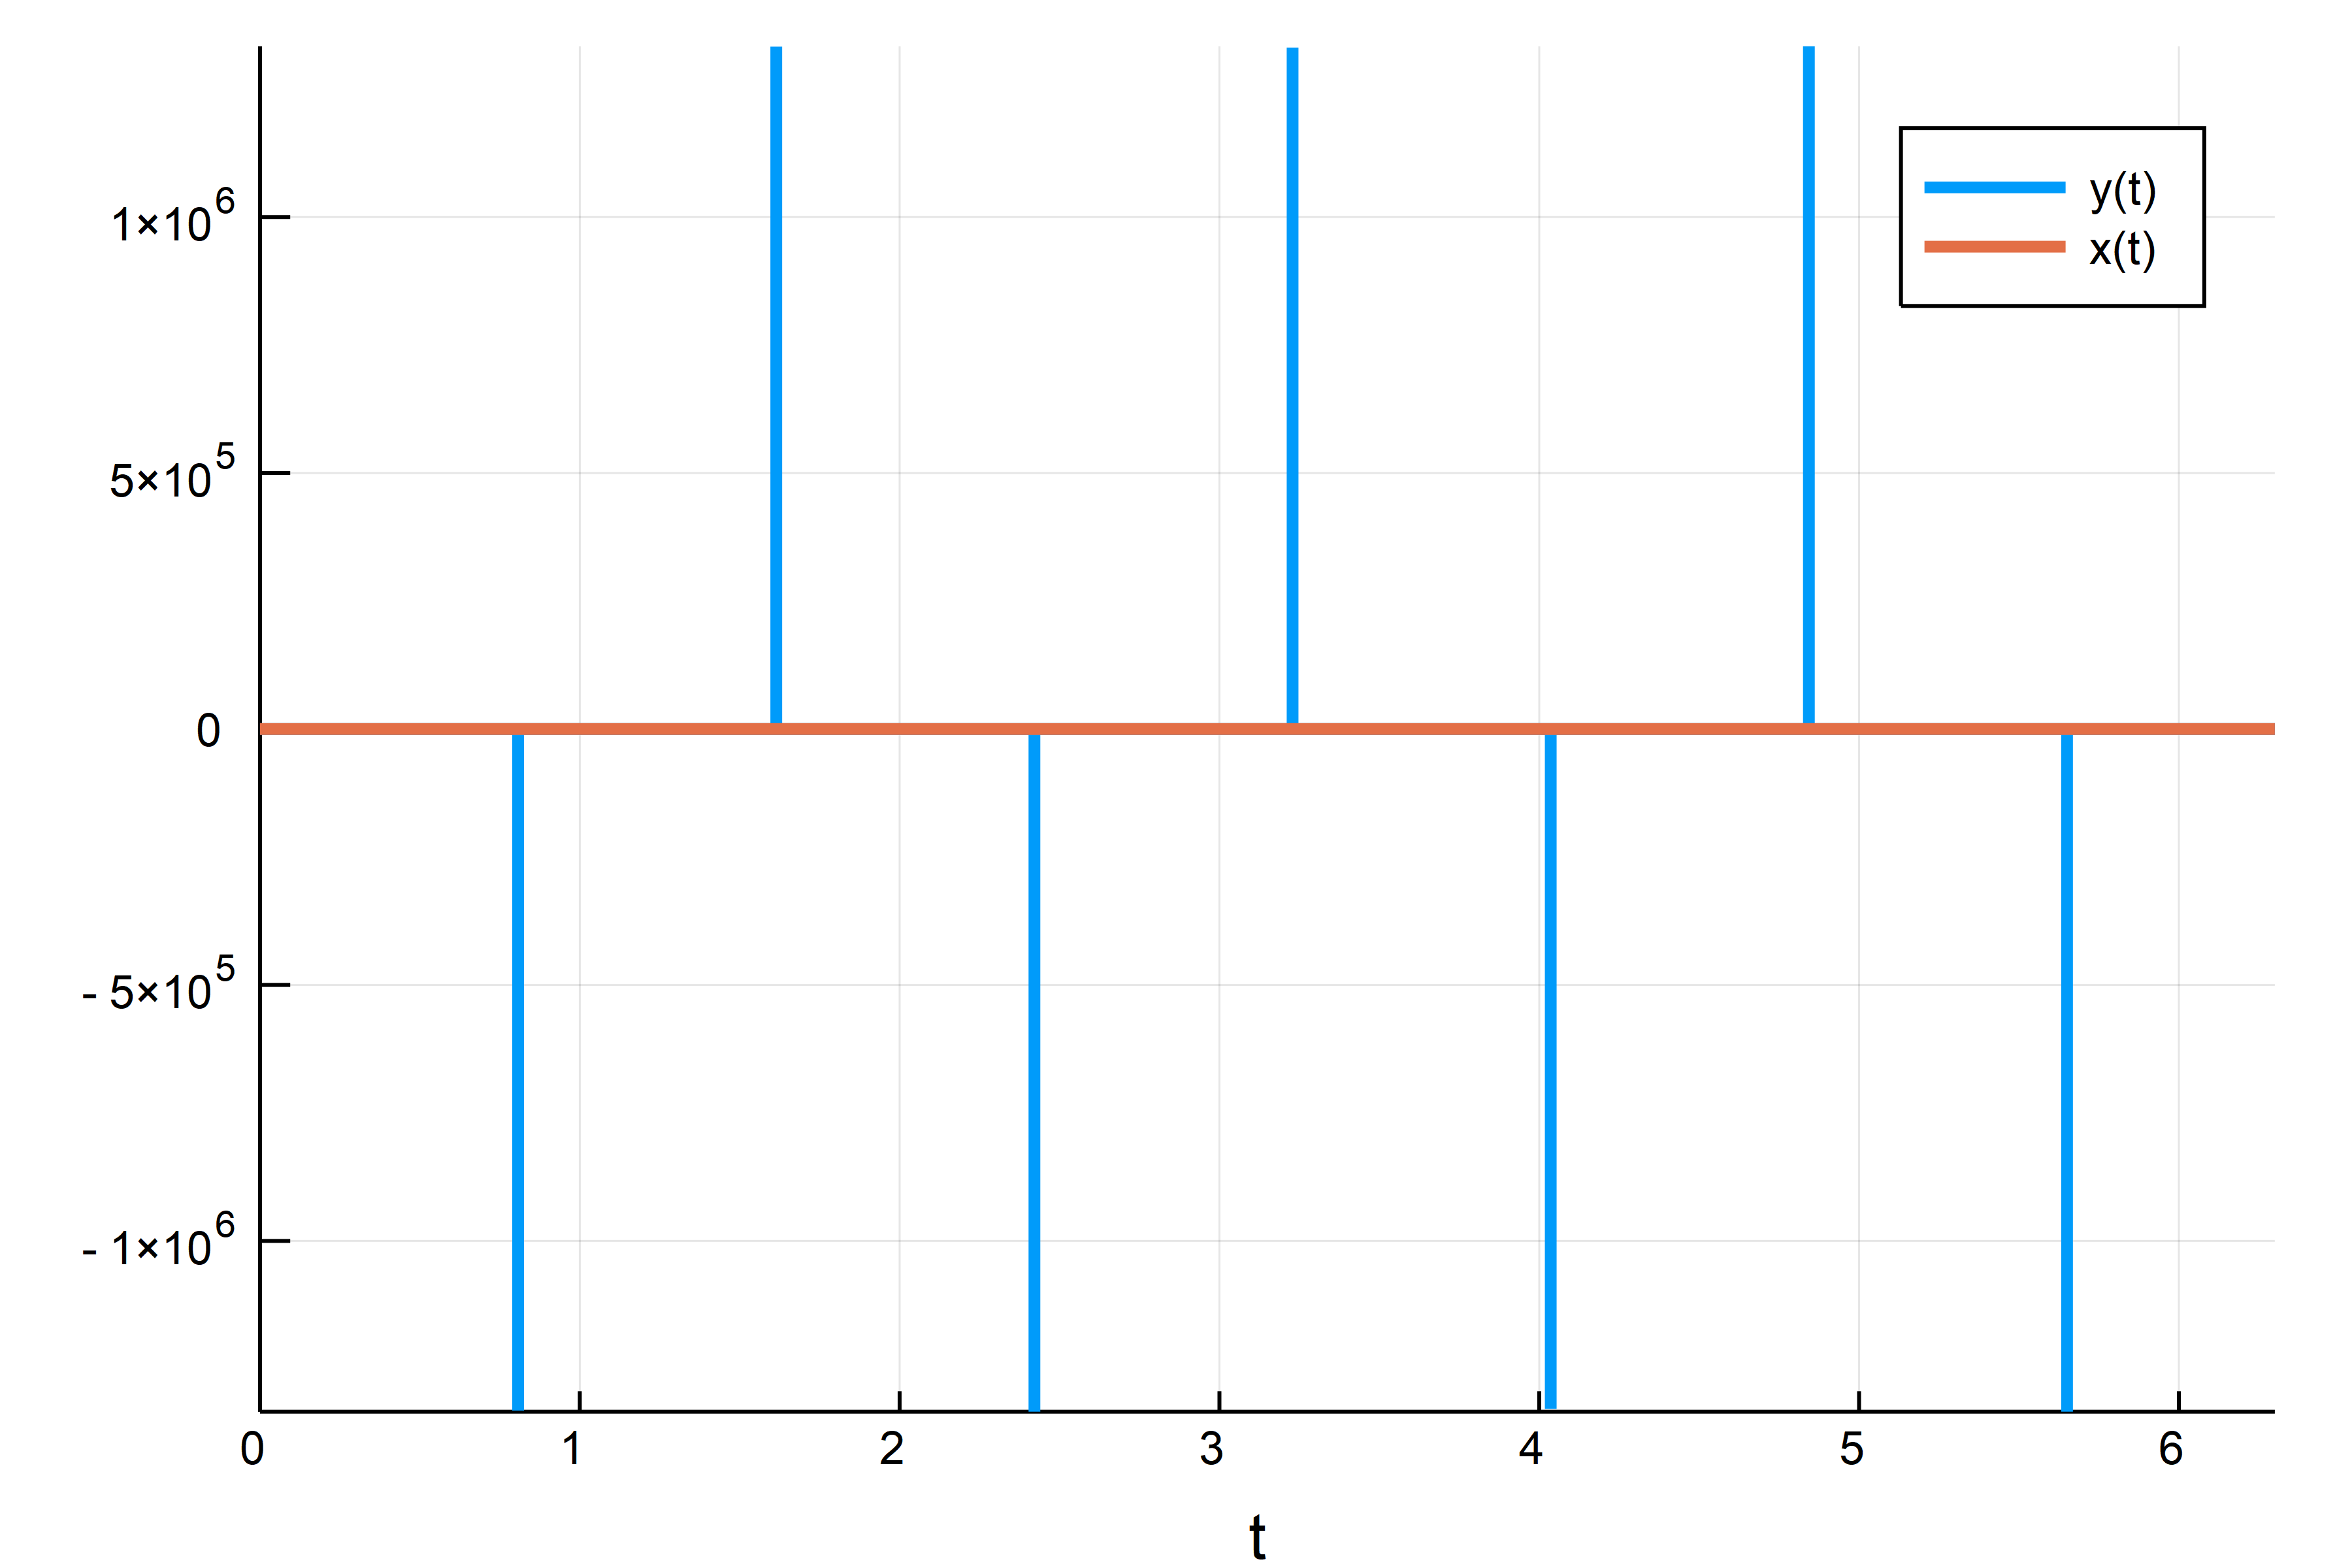

In [15]:
plot(sol)

## Omissions And Tweaking

The following were omitted from the tests due to convergence failures. ODE.jl's adaptivity is not able to stabilize its algorithms, while GeometricIntegrators.jl's methods either fail to converge at comparable dts (or on some computers errors due to type conversions).

In [34]:
sol = solve(prob,ode23s()); println("Total ODE.jl steps: $(length(sol))")
using GeometricIntegratorsDiffEq
try
    sol = solve(prob,GIRadIIA3(),dt=1/1000)
catch e
    println(e)
end

Total ODE.jl steps: 1


INFO: Precompiling module GeometricIntegratorsDiffEq.
ERROR: LoadError: ArgumentError: Module GeometricIntegrators not found in current path.
Run `Pkg.add("GeometricIntegrators")` to install the GeometricIntegrators package.
Stacktrace:
 [1] _require(::Symbol) at .\loading.jl:435
 [2] require(::Symbol) at .\loading.jl:405
 [3] include_from_node1(::String) at .\loading.jl:576
 [4] include(::String) at .\sysimg.jl:14
 [5] anonymous at .\<missing>:2
while loading C:\Users\Chris\.julia\v0.6\GeometricIntegratorsDiffEq\src\GeometricIntegratorsDiffEq.jl, in expression starting on line 8


LoadError: [91mFailed to precompile GeometricIntegratorsDiffEq to C:\Users\Chris\.julia\lib\v0.6\GeometricIntegratorsDiffEq.ji.[39m

`ARKODE` needs a lower `nonlinear_convergence_coefficient` in order to not diverge.

In [17]:
sol = solve(prob,ARKODE(),abstol=1e-4,reltol=1e-2);


[ARKODE ERROR]  ARKode
  At t = 0.00811458 and h = 1.17389e-006, the error test failed repeatedly or with |h| = hmin.



In [18]:
sol = solve(prob,ARKODE(nonlinear_convergence_coefficient = 1e-6),abstol=1e-4,reltol=1e-1);

In [19]:
sol = solve(prob,ARKODE(order=3),abstol=1e-4,reltol=1e-1);


[ARKODE ERROR]  ARKode
  At t = 0.0357472 and h = 9.86529e-007, the error test failed repeatedly or with |h| = hmin.



In [20]:
sol = solve(prob,ARKODE(nonlinear_convergence_coefficient = 1e-6,order=3),abstol=1e-4,reltol=1e-1);

In [39]:
sol = solve(prob,ARKODE(order=5,nonlinear_convergence_coefficient = 1e-3),abstol=1e-4,reltol=1e-1);


[ARKODE ERROR]  ARKode
  At t = 0.18602 and h = 7.10784e-006, the error test failed repeatedly or with |h| = hmin.



In [40]:
sol = solve(prob,ARKODE(order=5,nonlinear_convergence_coefficient = 1e-4),abstol=1e-4,reltol=1e-1);

## Low Order and High Tolerance

This tests the case where accuracy is not needed as much and quick robust solutions are necessary. Note that `ARKODE`'s convergence coefficient must be lowered to `1e-7` in order to converge.

#### Final timepoint error

This measures the efficiency to get the value at the endpoint correct.

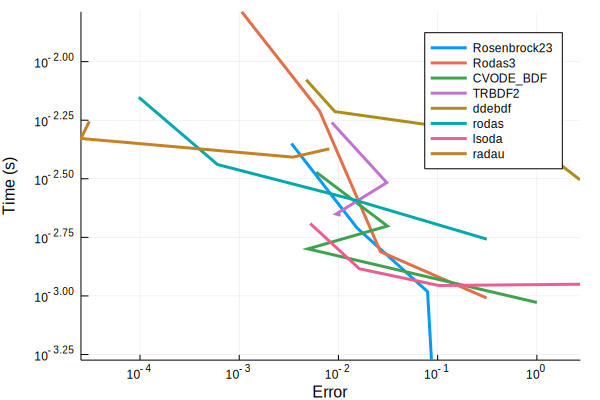

In [32]:
abstols = 1./10.^(4:7)
reltols = 1./10.^(1:4)

setups = [Dict(:alg=>Rosenbrock23()),
          Dict(:alg=>Rodas3()),
          Dict(:alg=>CVODE_BDF()),
          Dict(:alg=>TRBDF2()),
          Dict(:alg=>ddebdf()),
          Dict(:alg=>rodas()),
          Dict(:alg=>lsoda()),
          Dict(:alg=>radau())]
names = ["Rosenbrock23" "Rodas3" "CVODE_BDF" "TRBDF2" "ddebdf" "rodas" "lsoda" "radau"]
wp = WorkPrecisionSet(prob,abstols,reltols,setups;
                      names=names,save_everystep=false,appxsol=test_sol,maxiters=Int(1e5))
gr(fmt=:svg)
plot(wp)

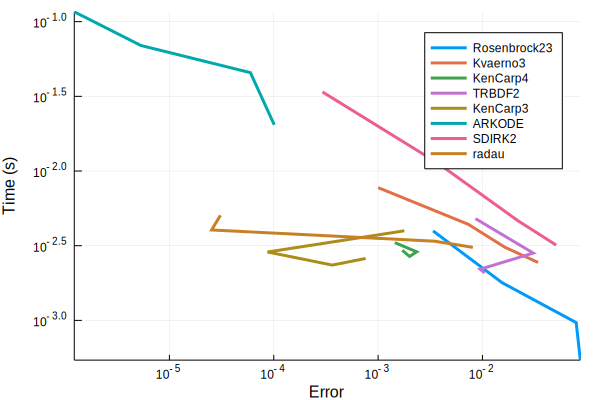

In [31]:
setups = [Dict(:alg=>Rosenbrock23()),
          Dict(:alg=>Kvaerno3()),
          Dict(:alg=>KenCarp4()),
          Dict(:alg=>TRBDF2()),
          Dict(:alg=>KenCarp3()),
          Dict(:alg=>ARKODE(nonlinear_convergence_coefficient = 1e-6)),
          Dict(:alg=>SDIRK2()),
          Dict(:alg=>radau())]
names = ["Rosenbrock23" "Kvaerno3" "KenCarp4" "TRBDF2" "KenCarp3" "ARKODE" "SDIRK2" "radau"]
wp = WorkPrecisionSet(prob,abstols,reltols,setups;
                      names=names,save_everystep=false,appxsol=test_sol,maxiters=Int(1e5))
plot(wp)

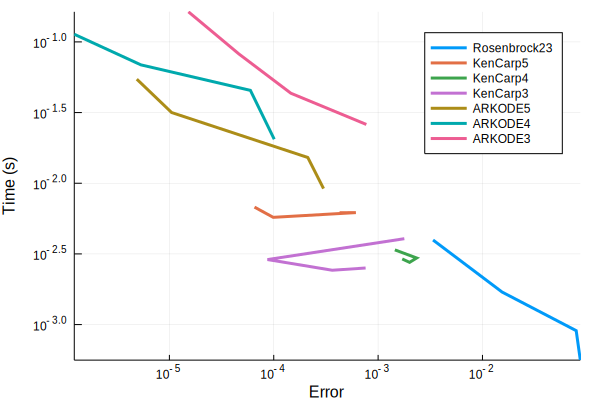

In [42]:
setups = [Dict(:alg=>Rosenbrock23()),
          Dict(:alg=>KenCarp5()),
          Dict(:alg=>KenCarp4()),
          Dict(:alg=>KenCarp3()),
          Dict(:alg=>ARKODE(order=5,nonlinear_convergence_coefficient = 1e-4)),
          Dict(:alg=>ARKODE(nonlinear_convergence_coefficient = 1e-6)),
          Dict(:alg=>ARKODE(nonlinear_convergence_coefficient = 1e-6,order=3))]
names = ["Rosenbrock23" "KenCarp5" "KenCarp4" "KenCarp3" "ARKODE5" "ARKODE4" "ARKODE3"]
wp = WorkPrecisionSet(prob,abstols,reltols,setups;
                      names=names,save_everystep=false,appxsol=test_sol,maxiters=Int(1e5))
plot(wp)

Notice that `KenCarp4` is the same overarching algorithm as `ARKODE` here (with major differences to stage predictors and adaptivity though). In this case, `KenCarp4` is more robust and more efficient than `ARKODE`. `CVODE_BDF` does quite well here, which is unusual for it on small equations. You can see that the low-order Rosenbrock methods `Rosenbrock23` and `Rodas3` dominate this test.

#### Timeseries error

Now we measure the average error of the timeseries.

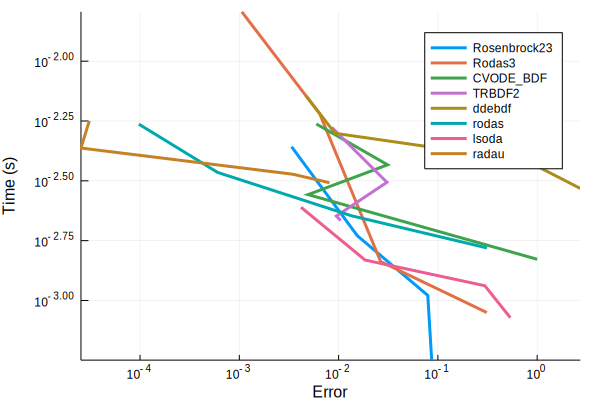

In [43]:
abstols = 1./10.^(4:7)
reltols = 1./10.^(1:4)

setups = [Dict(:alg=>Rosenbrock23()),
          Dict(:alg=>Rodas3()),
          Dict(:alg=>CVODE_BDF()),
          Dict(:alg=>TRBDF2()),
          Dict(:alg=>ddebdf()),
          Dict(:alg=>rodas()),
          Dict(:alg=>lsoda()),
          Dict(:alg=>radau())]
names = ["Rosenbrock23" "Rodas3" "CVODE_BDF" "TRBDF2" "ddebdf" "rodas" "lsoda" "radau"]
wp = WorkPrecisionSet(prob,abstols,reltols,setups;
                      names=names,error_estimator=:l2,appxsol=test_sol2,maxiters=Int(1e5))
plot(wp)

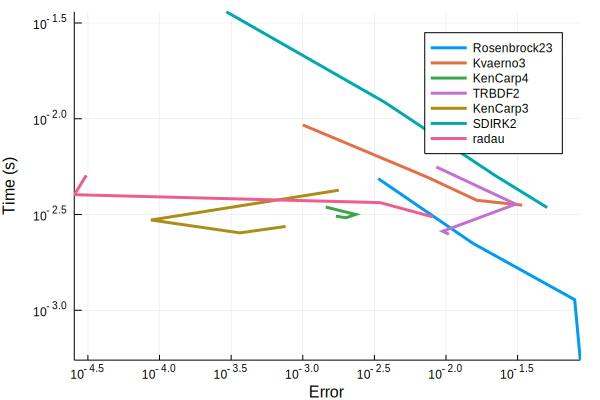

In [44]:
setups = [Dict(:alg=>Rosenbrock23(),:dense=>false),
          Dict(:alg=>Kvaerno3(),:dense=>false),
          Dict(:alg=>KenCarp4(),:dense=>false),
          Dict(:alg=>TRBDF2(),:dense=>false),
          Dict(:alg=>KenCarp3(),:dense=>false),
          Dict(:alg=>SDIRK2(),:dense=>false),
          Dict(:alg=>radau())]
names = ["Rosenbrock23" "Kvaerno3" "KenCarp4" "TRBDF2" "KenCarp3" "SDIRK2" "radau"]
wp = WorkPrecisionSet(prob,abstols,reltols,setups;
                      names=names,appxsol=test_sol2,maxiters=Int(1e5),error_estimator=:l2)
plot(wp)

### Higher accuracy tests

Now we transition to higher accracy tests. In this domain higher order methods are stable and much more efficient.

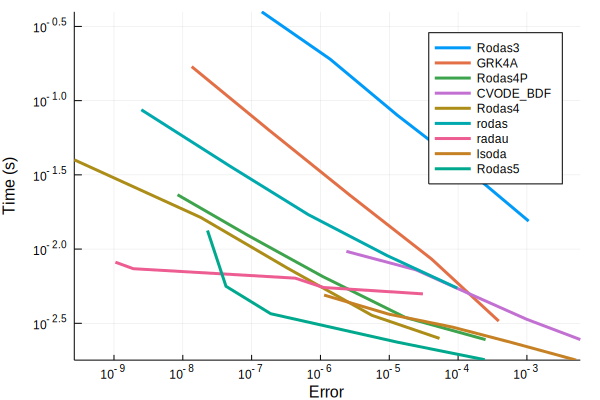

In [45]:
abstols = 1./10.^(7:11)
reltols = 1./10.^(4:8)
setups = [Dict(:alg=>Rodas3()),
          Dict(:alg=>GRK4A()),
          Dict(:alg=>Rodas4P()),
          Dict(:alg=>CVODE_BDF()),
          Dict(:alg=>Rodas4()),
          Dict(:alg=>rodas()),
          Dict(:alg=>radau()),
          Dict(:alg=>lsoda()),
          Dict(:alg=>Rodas5())]
names = ["Rodas3" "GRK4A" "Rodas4P" "CVODE_BDF" "Rodas4" "rodas" "radau" "lsoda" "Rodas5"]
wp = WorkPrecisionSet(prob,abstols,reltols,setups;
                      names=names,save_everystep=false,appxsol=test_sol,maxiters=Int(1e6))
plot(wp)

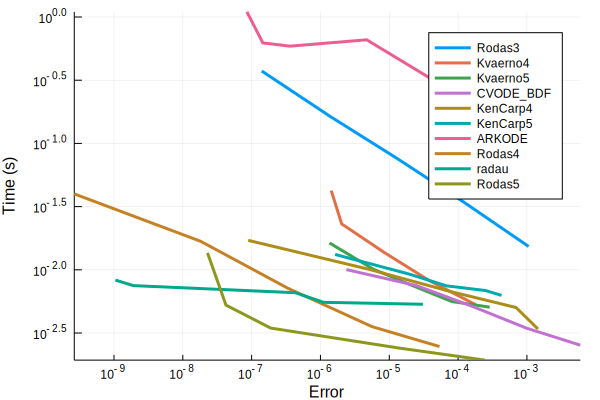

In [46]:
abstols = 1./10.^(7:11)
reltols = 1./10.^(4:8)
setups = [Dict(:alg=>Rodas3()),
          Dict(:alg=>Kvaerno4()),
          Dict(:alg=>Kvaerno5()),
          Dict(:alg=>CVODE_BDF()),
          Dict(:alg=>KenCarp4()),
          Dict(:alg=>KenCarp5()),
          Dict(:alg=>ARKODE()),
          Dict(:alg=>Rodas4()),
          Dict(:alg=>radau()),
          Dict(:alg=>Rodas5())]
names = ["Rodas3" "Kvaerno4" "Kvaerno5" "CVODE_BDF" "KenCarp4" "KenCarp5" "ARKODE" "Rodas4" "radau" "Rodas5"]
wp = WorkPrecisionSet(prob,abstols,reltols,setups;
                      names=names,save_everystep=false,appxsol=test_sol,maxiters=Int(1e6))
plot(wp)

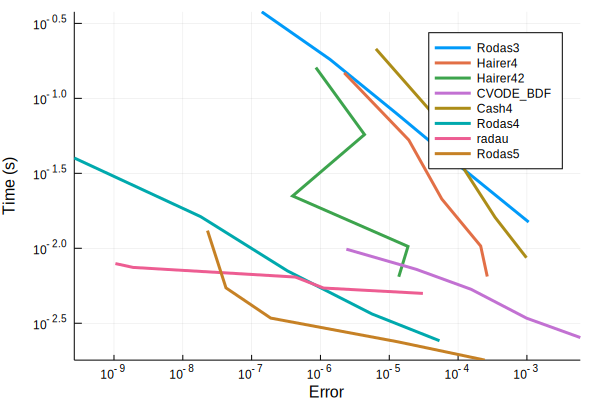

In [47]:
setups = [Dict(:alg=>Rodas3()),
          Dict(:alg=>Hairer4()),
          Dict(:alg=>Hairer42()),
          Dict(:alg=>CVODE_BDF()),
          Dict(:alg=>Cash4()),
          Dict(:alg=>Rodas4()),
          Dict(:alg=>radau()),
          Dict(:alg=>Rodas5())]
names = ["Rodas3" "Hairer4" "Hairer42" "CVODE_BDF" "Cash4" "Rodas4" "radau" "Rodas5"]
wp = WorkPrecisionSet(prob,abstols,reltols,setups;
                      names=names,save_everystep=false,appxsol=test_sol,maxiters=Int(1e6))
plot(wp)

#### Timeseries Errors

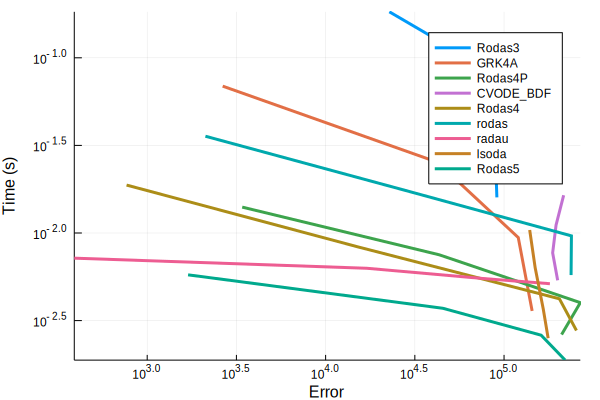

In [48]:
abstols = 1./10.^(7:10)
reltols = 1./10.^(4:7)
setups = [Dict(:alg=>Rodas3()),
          Dict(:alg=>GRK4A()),
          Dict(:alg=>Rodas4P()),
          Dict(:alg=>CVODE_BDF()),
          Dict(:alg=>Rodas4()),
          Dict(:alg=>rodas()),
          Dict(:alg=>radau()),
          Dict(:alg=>lsoda()),
          Dict(:alg=>Rodas5())]
names = ["Rodas3" "GRK4A" "Rodas4P" "CVODE_BDF" "Rodas4" "rodas" "radau" "lsoda" "Rodas5"]
wp = WorkPrecisionSet(prob,abstols,reltols,setups;
                      names=names,appxsol=test_sol2,maxiters=Int(1e6),error_estimate=:l2)
plot(wp)

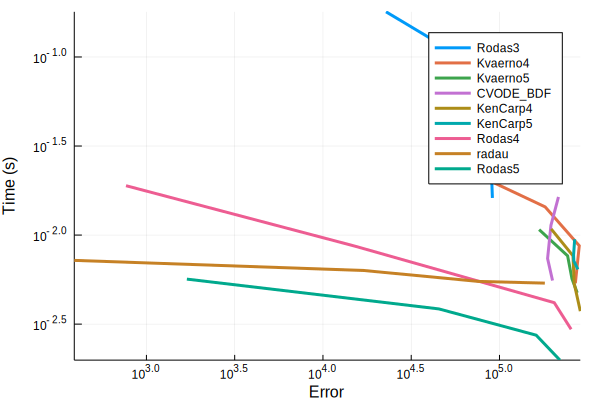

In [49]:
setups = [Dict(:alg=>Rodas3()),
          Dict(:alg=>Kvaerno4()),
          Dict(:alg=>Kvaerno5()),
          Dict(:alg=>CVODE_BDF()),
          Dict(:alg=>KenCarp4()),
          Dict(:alg=>KenCarp5()),
          Dict(:alg=>Rodas4()),
          Dict(:alg=>radau()),
          Dict(:alg=>Rodas5())]
names = ["Rodas3" "Kvaerno4" "Kvaerno5" "CVODE_BDF" "KenCarp4" "KenCarp5" "Rodas4" "radau" "Rodas5"]
wp = WorkPrecisionSet(prob,abstols,reltols,setups;
                      names=names,appxsol=test_sol2,maxiters=Int(1e6),error_estimate=:l2)
plot(wp)

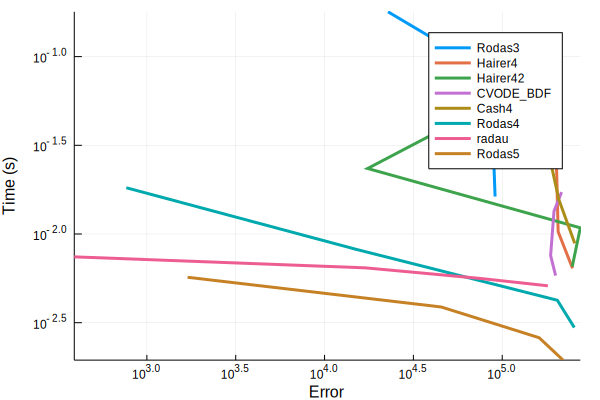

In [50]:
setups = [Dict(:alg=>Rodas3()),
          Dict(:alg=>Hairer4()),
          Dict(:alg=>Hairer42()),
          Dict(:alg=>CVODE_BDF()),
          Dict(:alg=>Cash4()),
          Dict(:alg=>Rodas4()),
          Dict(:alg=>radau()),
          Dict(:alg=>Rodas5())]
names = ["Rodas3" "Hairer4" "Hairer42" "CVODE_BDF" "Cash4" "Rodas4" "radau" "Rodas5"]
wp = WorkPrecisionSet(prob,abstols,reltols,setups;
                      names=names,appxsol=test_sol2,maxiters=Int(1e6),error_estimate=:l2)
plot(wp)

The timeseries test is a little odd here because of the high peaks in the VanDerPol oscillator. At a certain accuracy, the steps try to resolve those peaks and so the error becomes higher. 

While the higher order order Julia-based Rodas methods (`Rodas4` and `Rodas4P`) Rosenbrock methods are not viable at higher tolerances, they dominate for a large portion of this benchmark. When the tolerance gets low enough, `radau` adaptive high order (up to order 13) takes the lead.

### Conclusion

`Rosenbrock23` and `Rodas3` do well when tolerances are higher. In most standard tolerances, `Rodas4` and `Rodas4P` do extremely well. Only when the tolerances get very low does `radau` do well. The Julia Rosenbrock methods vastly outperform their Fortran counterparts. `CVODE_BDF` is a top performer in the final timepoint errors with low accuracy, but take that with a grain of salt because the problem is periodic which means it's getting the spikes wrong but the low parts correct. `ARKODE` does poorly in these tests. `lsoda` does quite well in both low and high accuracy domains, but is never the top.

## Details

In [28]:
versioninfo()

Julia Version 0.6.2
Commit d386e40c17* (2017-12-13 18:08 UTC)
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: Intel(R) Core(TM) i7-4770K CPU @ 3.50GHz
  WORD_SIZE: 64
  BLAS: libopenblas (USE64BITINT DYNAMIC_ARCH NO_AFFINITY Haswell)
  LAPACK: libopenblas64_
  LIBM: libopenlibm
  LLVM: libLLVM-3.9.1 (ORCJIT, haswell)


In [1]:
Pkg.status()

58 required packages:
 - ApproxFun                     0.8.0
 - Atom                          0.6.12
 - BSON                          0.1.3
 - BenchmarkTools                0.3.0
 - BlackBoxOptim                 0.3.0
 - CLArrays                      0.1.3
 - CSV                           0.1.5
 - Cbc                           0.3.2
 - Clustering                    0.9.1
 - DASKR                         1.0.0
 - DataFrames                    0.10.1
 - DiffEqBayes                   0.4.0
 - DiffEqOperators               1.2.0
 - DiffEqProblemLibrary          2.4.1
 - DifferentialEquations         4.5.0
 - FastGaussQuadrature           0.3.0
 - Flux                          0.5.1
 - GLM                           0.8.1
 - GR                            0.31.0
 - Gadfly                        0.6.5
 - Gillespie                     0.0.2
 - HigherPrecision               0.1.3
 - IJulia                        1.8.0
 - Interact                      0.7.2
 - IntervalArithmetic            0.13.0

 - MultiScaleArrays              0.7.0
 - Mustache                      0.3.2
 - Mux                           0.2.3
 - NLSolversBase                 4.4.1
 - NLsolve                       1.0.0              deed60a6 (dirty)
 - NNlib                         0.3.0
 - NaNMath                       0.3.1
 - NamedArrays                   0.7.0
 - NearestNeighbors              0.3.0
 - NullableArrays                0.1.2
 - Nullables                     0.0.5
 - Nulls                         0.1.2
 - ODEInterface                  0.1.5
 - OffsetArrays                  0.5.0
 - OnlineStats                   0.17.3
 - OnlineStatsBase               0.7.0
 - OpenCL                        0.7.0
 - Optim                         0.14.1
 - OptimBase                     1.0.0
 - OrdinaryDiffEq                3.12.0
 - OrdinaryDiffEqExtendedTests   0.0.0-             master (unregistered)
 - PDMats                        0.8.0
 - PKPDSimulator                 0.0.0-             sb/lang (unregistered)